# Customer segmentation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cluster.cluster_functions import *
from cluster.plotting import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin_min

# sns.set()
%load_ext autoreload
%autoreload 2

**The data**

Each row of the table consists of a transaction which belongs to an invoice which in turn belongs to a customer. There are 3 identifier columns in the table:

1. StockCode - Stock ID of the item being purchased in the transaction
2. InvoiceNo - The invoice ID of the invoice that the item being purchased belongs to
3. CustomerID - The customer ID of the customer that the invoice belongs to

In [2]:
invoices = pd.read_csv("data/retail/invoices_2009_2011_no_returns.csv", low_memory=False)
invoices['InvoiceDate'] = pd.to_datetime(invoices['InvoiceDate'])
invoices.dropna(inplace=True)
invoices.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


The data appears to be a join between 3 tables in a relational database, a Customer table, Order table, and a Item table. We can create customer level purchase features by grouping by Customer ID and Invoice Date. Transactions will be grouped daily to create purchase days for each customer, where all transactions made on the same day by the same customer forms a "purchase day" with a given "purchase value" equal to the total revenue of all transactions made on that day.

Customers will be segmentated based on features created from their first year transaction histories. Eligible customers are those who had three or more purchase days in the first year (2009-12-1 : 2010-12-1) since three purchase days is just enough to create the aggregation features necessary to cluster on. The segments are then evaluated based on the total value of their second year purchase days. An example of the first year transaction history for one of the customers eligible for segmentation is seen below: 

In [3]:
cohort_customer_ids = invoices[invoices.InvoiceDate<'2010-12-1'].CustomerID.unique()
cohort_invoices = invoices[invoices.CustomerID.isin(cohort_customer_ids)]
cohort_invoices[(cohort_invoices['CustomerID']==16784) & (cohort_invoices.InvoiceDate<'2010-12-1')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
135782,502838,22553,PLASTERS IN TIN SKULLS,1,2010-03-28 12:55:00,1.65,16784.0,United Kingdom,1.65
135783,502838,22554,PLASTERS IN TIN WOODLAND ANIMALS,1,2010-03-28 12:55:00,1.65,16784.0,United Kingdom,1.65
135784,502838,21221,SET/4 BADGES CUTE CREATURES,1,2010-03-28 12:55:00,1.25,16784.0,United Kingdom,1.25
135785,502838,22443,GROW YOUR OWN HERBS SET OF 3,1,2010-03-28 12:55:00,7.95,16784.0,United Kingdom,7.95
135786,502838,47567,TEA TIME KITCHEN APRON,1,2010-03-28 12:55:00,5.95,16784.0,United Kingdom,5.95
135787,502838,21042,RED SPOTTY APRON,1,2010-03-28 12:55:00,5.95,16784.0,United Kingdom,5.95
135788,502838,22288,"DECORATION , HANGING METAL RABBIT",3,2010-03-28 12:55:00,1.25,16784.0,United Kingdom,3.75
135789,502838,22289,"DECORATION , HANGING METAL CHICKEN",3,2010-03-28 12:55:00,1.25,16784.0,United Kingdom,3.75
135790,502838,85188,PINK METAL SWINGING BUNNY,3,2010-03-28 12:55:00,0.85,16784.0,United Kingdom,2.55
135791,502838,85188,GREEN METAL SWINGING BUNNY,3,2010-03-28 12:55:00,0.85,16784.0,United Kingdom,2.55


This customer made 157 transactions in their first year but only on 3 separate purchase days. A few questions we could ask about this customer are:

1. Is this customer likely to make frequent and/or high value purchases in the following year?. 
2. Should we consider him/her a low, medium or high value customer? 
3. What does this person's purchasing habits tell us about the type of customer they are?
4. What is the right marketing strategy to increase profitability for this customer in the future?. 

Answering these questions gives us some actionable insight and dictates what we should do next to maximize the lifetime value of each customer. Not all of the questions are able to be answered based on transaction history alone. Question 3 requires profiling information whilst question 4 requires further analysis to figure out which aspect of the [marketing mix](https://marketingmix.co.uk/) to employ. But segmentations can still be made with the data at hand and therefore potential insight can be obtained.

This customer was later identified to be a low value customer by the aggregation feature clustering below but I'll talk more about this later in the appropriate section.

<br>
<br>

# Cluster on RFM features (naive approach)

RFM (recency, frequency and monetary) has been a pillar of database marketing for 75 years. The three features are created for each customer based on their transaction history. They are defined as follows for this dataset (with an additional "Age" feature which gives the same information as Recency):

**Frequency** - the number of repeat purchase days the customer had in their first year. This means that it’s one less than the total number of purchase days.

**Age (T)** - the age of the customer in whatever time units chosen (daily for this data). This is equal to the duration between a customer’s first purchase day and the end of the period under study (1 year).

**Recency** - the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase day and their latest purchase day.

**Monetary Value** - The average monetary value of each repeat purchase day. We exclude the customer's first transaction in the average.

It is used by many firms to quantify engagement of a customer and is considered to be a financial tool to identify the best customers based on transaction history, where the idea is customers with the highest RFM are the most valuable customers. However it is **not** considered a marketing technique. According to Mike Grigsby in his book "Marketing Analytics":

>The focus is not about customer behaviour, not about what the customer needs, why those with a high score are so involved or why those with a low score are not so engaged. The point is to make a (financial) return on a database, not to understand customer behaviour. That is, the motivation is financial and not marketing.

Admittedly, the segmentations produced in this analysis by me was also financially driven, but there is only so much you can do with the 9 columns in this dataset to understand customer behaviour. Before continuing the discussion on what other features should be included in an ideal segmentation, let's have a look at how KMeans and GMM segments the customers based on RFM (ignore the other features in the table for now).

**KMeans**

In [4]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_time_aggregation_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,12356.0,798.44,840.956062,349.85,1977.96,3126.25,3,21.5,13.435029,12.0,31.0,2.0,44.0,50.0,1163.905,155.0,2487.43
1,12358.0,821.08,581.088065,268.10,1429.83,2519.01,3,177.5,4.949747,174.0,181.0,2.0,356.0,357.0,544.590,30.0,928.06
2,12359.0,417.70,231.086670,78.20,760.69,2563.36,6,81.0,45.850845,11.0,110.0,5.0,309.0,360.0,360.534,64.0,6372.58
3,12360.0,502.04,291.890867,118.00,690.79,1310.83,3,131.5,55.861436,92.0,171.0,2.0,263.0,281.0,596.415,33.0,2302.06
4,12361.0,94.20,8.127782,83.15,99.00,276.35,3,109.5,9.192388,103.0,116.0,2.0,220.0,308.0,91.075,1.0,174.90


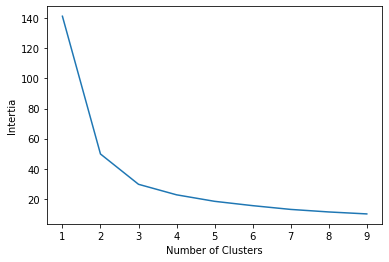

In [5]:
cluster_feature_names = [
    'recency',
    'frequency',
    'monetary_value'   
]
scaler = MinMaxScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)
cluster_elbow_method(cluster_features)

Pick the best number of clusters using the "[elbow method](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)"

Inertia for 3 clusters: 29.634516591432224
Cluster labels - 0 = Low value customer, 2 = High value customer
Silhouette Coefficient:0.8769330158063914
Mean 2nd year RLV: [1556.226 2077.335 5250.781]
Differences: [521.11, 3173.45]
Value Counts:
0    696
1    454
2    749
Name: Cluster, dtype: int64
Explained variance ratio: [0.89842138 0.05825198]
Total explained variance: 0.9566733587534939


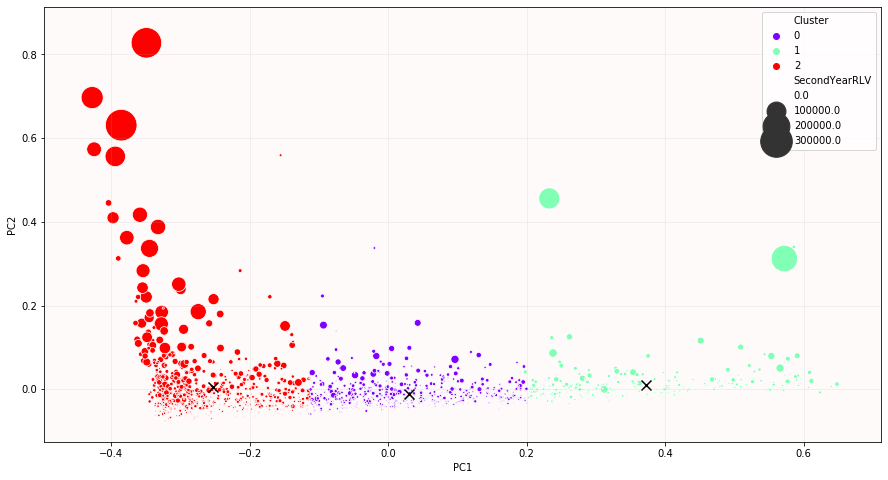

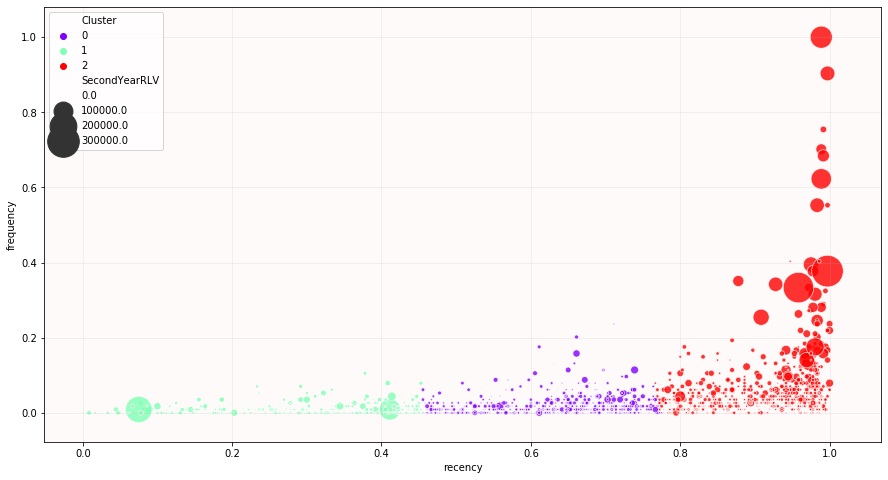

In [6]:
num_clusters = 3
cluster_features, cluster_centers  = perform_km_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

**Mean cluster features**

In [7]:
features_copy = pd.DataFrame(
    scaler.inverse_transform(cluster_features[cluster_feature_names]),
    columns = cluster_features[cluster_feature_names].columns
)
features_copy = pd.concat([features_copy, cluster_features[['Cluster', 'SecondYearRLV']]], axis=1)
features_copy.groupby('Cluster').mean()

,recency,frequency,monetary_value,SecondYearRLV
Cluster,,,,
0,229.958333,4.189655,407.785262,1556.225589
1,106.204846,3.024229,409.645639,2077.335044
2,330.562083,9.114820,508.858033,5250.781375


In [8]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=cluster_feature_names,
    index=['Component 1', 'Component 2']
)

,recency,frequency,monetary_value
Component 1,-0.994995,-0.097647,-0.021201
Component 2,-0.082719,0.685911,0.722968


Min-Max scaling was used to make sure all features are on a similar scale to ensure euclidean distance is a suitable measure of similarity. Normalization was also tried but resulted in very uneven cluster distributions (I implement my own fix for this later by transforming the cluster features). The first figure shows the segments with the cluster features (RFM) reduced to two dimensions so that they can be plot in 2D. The second figure shows the segments in a recency-frequency plot. Both figures show the total purchase value of all second year purchase days for each customer using the size of the markers. I call this "SecondYearRlV" where RLV stands for Residual Lifetime Value, a marketing term which comes from [Customer Lifetime Value analysis and BTYD modelling](https://medium.com/@josh.temple/how-to-estimate-the-value-of-your-customers-the-right-way-57c63fad093). It is the amount of additional value we expect to collect from a customer over a given time period.

Notice that no data is given regarding whether a transaction from a customer is a repeat transaction or not, so we cannot know if a transaction recorded in the second year of the dataset is actually a second year transaction for a given customer (since the customer could be an existing one from before the timespan of this dataset), therefore BTYD modelling, which is a more suitable statistical method for modelling CLV/RLV of a customer, cannot be performed on this dataset.

Simple band segments were created when clustering on RFM. Two noticeable outliers are present in the green segment, but the most damning aspect is the fact that customers in cluster 1, which have a lower mean RF than cluster 0 customers, ended up with higher mean second year RLV! The simple rule of higher RFM = better customer seems to be broken here. There are a bunch of different ways firms like to use RFM to segment customers, usually a more rudimentary [scoring method](https://en.wikipedia.org/wiki/RFM_(market_research) is used, but clustering on RFM should produce similar results since similar RFM values should end up with similar scores anyway. I doubt the scoring method will do any better, but maybe I'll check this in a later version of this notebook.

The bottom line is, using KMeans to segment customers based on RFM to identify high value short-term future spenders doesn't perform so hot. Can we do better with a different clustering algorithm?

**GMM**

In [9]:
cluster_feature_names = [
    'recency',
    'frequency',
    'monetary_value'   
]
scaler = MinMaxScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)

Cluster labels - 0 = Low value customer, 2 = High value customer
Silhouette Coefficient:0.7498625187657645
Mean 2nd year RLV: [ 1015.691  2268.33  16131.487]
Differences: [1252.64, 13863.16]
Value Counts:
0    895
1    804
2    200
Name: Cluster, dtype: int64
Explained variance ratio: [0.89842138 0.05825198]
Total explained variance: 0.9566733587534938


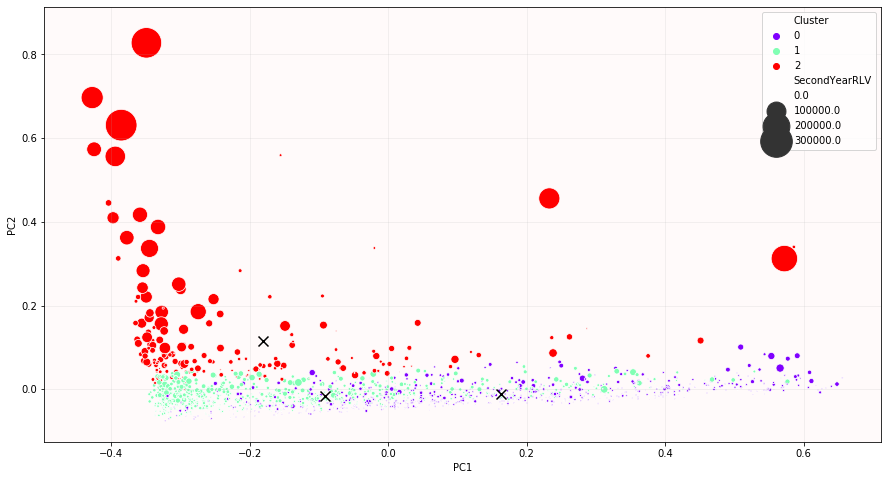

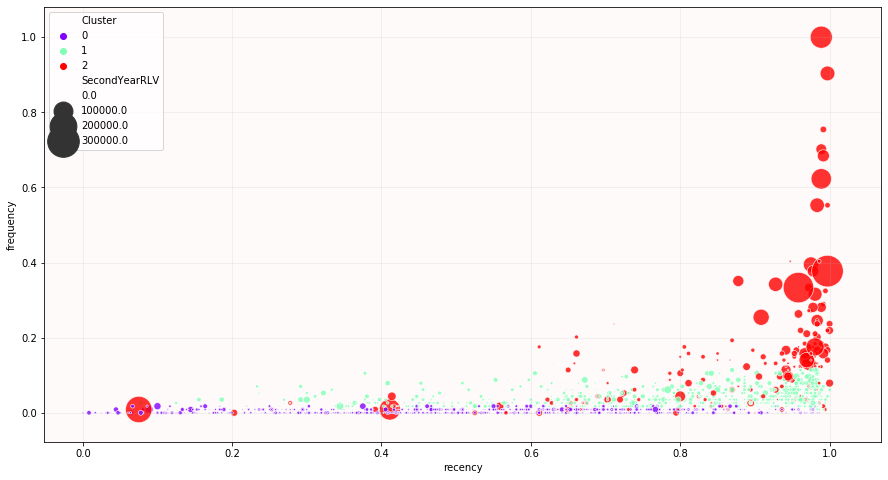

In [10]:
num_clusters = 3
cluster_features, cluster_centers, _  = perform_gmm_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

**Mean cluster features**

In [11]:
features_copy = pd.DataFrame(
    scaler.inverse_transform(cluster_features[cluster_feature_names]),
    columns = cluster_features[cluster_feature_names].columns
)
features_copy = pd.concat([features_copy, cluster_features[['Cluster', 'SecondYearRLV']]], axis=1)
features_copy.groupby('Cluster').mean()

,recency,frequency,monetary_value,SecondYearRLV
Cluster,,,,
0,191.560894,2.475978,369.199533,1015.691073
1,278.600746,6.651741,343.467648,2268.330149
2,302.085000,17.760000,1221.753793,16131.487100


In [12]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=cluster_feature_names,
    index=['Component 1', 'Component 2']
)

,recency,frequency,monetary_value
Component 1,-0.994995,-0.097647,-0.021201
Component 2,-0.082719,0.685911,0.722968


The two outliers are now correctly identified to be high value customers. Interestingly, the monetary value of cluster 1 customers is lower than cluster 0 customers, but this is more than made up for by the amount of repeat purchases they make. According to this segmentation, frequency is a better predictor than monetary value in predicting high value short-term future spenders.  The simple rule of higher RF means higher value customer seems to apply here. So there you have it, if one wants to segment customers into value groups using RFM with clustering rather than a scoring method, then use a cluster algorithm than doesn't assume [spherical clusters](https://www.quora.com/What-is-the-difference-between-K-means-and-the-mixture-model-of-Gaussian)

But the goal wasn't just to identify high value customers. We're trying to find value groups that we can employ different marketing strategies for. We want the groups to be different! What other purchasing behaviours can we include? Can we do better with the information given to us? Can we find more different looking customer segments? After all, according to Mike Grigsby:

>The general definition of a segment is that members are 'homogeneous within and heterogeneous between'

<br>
<br>

# Cluster on aggregation features

Let's get creative with the features and create some purchase behaviour indicators other than RFM. I will create aggregation features of purchase value which again is the total revenue of all transactions made on a given purchase day. These include Median/StDev/Min/Max/Sum/Size (size is equivalent to frequency in RFM but we now include all purchases). I will also create time aggregation features where I include the Median/StDev/Min/Max time between purchase days. Then cluster on all of these features to see if we can group together high value short-term future spenders, as well as create unique segments and understand more about the customers within each segment. 

**KMeans**

In [13]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_time_aggregation_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,12356.0,798.44,840.956062,349.85,1977.96,3126.25,3,21.5,13.435029,12.0,31.0,2.0,44.0,50.0,1163.905,155.0,2487.43
1,12358.0,821.08,581.088065,268.10,1429.83,2519.01,3,177.5,4.949747,174.0,181.0,2.0,356.0,357.0,544.590,30.0,928.06
2,12359.0,417.70,231.086670,78.20,760.69,2563.36,6,81.0,45.850845,11.0,110.0,5.0,309.0,360.0,360.534,64.0,6372.58
3,12360.0,502.04,291.890867,118.00,690.79,1310.83,3,131.5,55.861436,92.0,171.0,2.0,263.0,281.0,596.415,33.0,2302.06
4,12361.0,94.20,8.127782,83.15,99.00,276.35,3,109.5,9.192388,103.0,116.0,2.0,220.0,308.0,91.075,1.0,174.90


In [14]:
features_to_transform = [
    'MedianPurchaseValue',
    'StDevPurchaseValue',
    'MinPurchaseValue', 
    'MaxPurchaseValue', 
    'SumPurchaseValue',
    'SizePurchaseValue',
    'MedianTimeBetweenPurchase',
    'StDevTimeBetweenPurchase',
    'MinTimeBetweenPurchase',
    'MaxTimeBetweenPurchase',
]
features, transformed_feature_names, yjt = transform_features(features, features_to_transform, transform="yjt")
features.head()

,yjt_MedianPurchaseValue,yjt_StDevPurchaseValue,yjt_MinPurchaseValue,yjt_MaxPurchaseValue,yjt_SumPurchaseValue,yjt_SizePurchaseValue,yjt_MedianTimeBetweenPurchase,yjt_StDevTimeBetweenPurchase,yjt_MinTimeBetweenPurchase,yjt_MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,5.789114,5.365618,15.644784,3.224589,3.705797,0.706056,4.810429,3.379806,3.223952,7.144626,12356.0,2.0,44.0,50.0,1163.905,155.0,2487.43
1,5.809899,5.132718,14.216121,3.181008,3.669940,0.706056,11.021725,2.083714,8.320107,16.214547,12358.0,2.0,356.0,357.0,544.590,30.0,928.06
2,5.300495,4.525551,8.895903,3.084534,3.672903,0.794942,8.287425,5.433585,3.100379,13.005773,12359.0,5.0,309.0,360.0,360.534,64.0,6372.58
3,5.440558,4.682928,10.459276,3.068304,3.550225,0.706056,9.907941,5.812600,6.863877,15.816835,12360.0,2.0,263.0,281.0,596.415,33.0,2302.06
4,4.127572,2.048027,9.117004,2.634365,3.182981,0.706056,9.270728,2.847447,7.109999,13.319642,12361.0,2.0,220.0,308.0,91.075,1.0,174.90


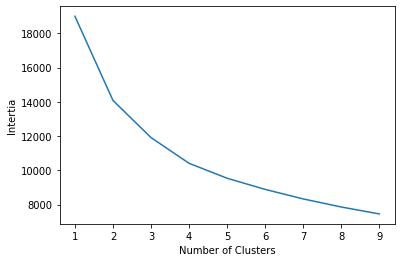

In [15]:
cluster_feature_names = transformed_feature_names
scaler = StandardScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)
cluster_elbow_method(cluster_features)

Inertia for 4 clusters: 10412.59887143287
Cluster labels - 0 = Low value customer, 3 = High value customer
Silhouette Coefficient:0.2501071599154528
Mean 2nd year RLV: [  512.273  1718.876  1727.919 11983.05 ]
Differences: [1206.6, 9.04, 10255.13]
Value Counts:
0    484
1    581
2    515
3    319
Name: Cluster, dtype: int64
Explained variance ratio: [0.41830064 0.2769082 ]
Total explained variance: 0.6952088410642039


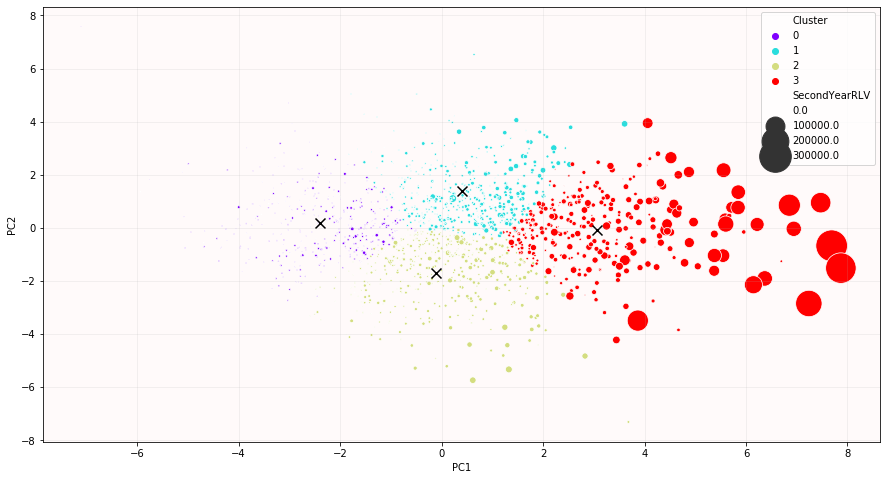

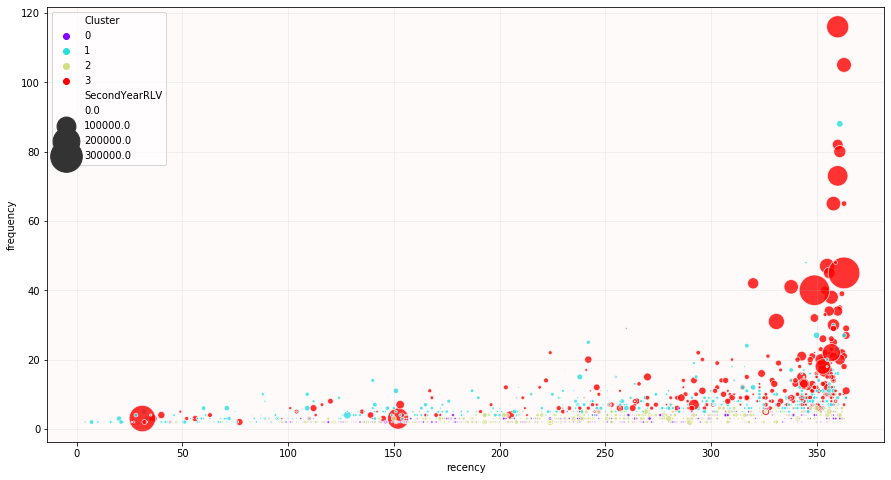

In [16]:
num_clusters = 4
cluster_features, cluster_centers  = perform_km_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [17]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=features_to_transform,
    index=['Component 1', 'Component 2']
)

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase
Component 1,0.297597,0.337401,0.069660,0.389678,0.446685,0.344361,-0.330561,-0.238875,-0.280295,-0.279081
Component 2,-0.415640,-0.252700,-0.411593,-0.327157,-0.168908,0.228350,-0.365923,-0.260104,-0.308154,-0.331299


**Mean Cluster Features**

In [18]:
features_copy = features.copy()

# Inverse transform to see cluster features
if yjt:
    features_copy.drop(columns=transformed_feature_names, inplace=True)
    features_copy = pd.concat([
        pd.DataFrame(yjt.inverse_transform(features[transformed_feature_names]), columns=features_to_transform),
        features_copy
    ], axis=1)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
else:
    for transf_col, col in zip(transformed_feature_names, features_to_transform):
        features_copy[transf_col] = np.exp(features_copy[transf_col]) - 1
        features_copy.rename(columns={transf_col:col}, inplace=True)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
features_copy.groupby("Cluster").mean()

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
Cluster,,,,,,,,,,,,,,,,,
0,208.386271,82.346487,137.590868,308.469525,794.233967,3.723140,84.203512,62.937651,41.138430,146.367769,15561.000000,2.723140,233.206612,284.460744,216.060500,84.735537,512.273450
1,256.362160,126.314776,128.318571,468.680637,2028.674131,7.707401,30.098107,23.335566,11.270224,70.604131,15472.641997,6.707401,216.261618,257.839931,266.055328,86.170396,1718.875886
2,556.565544,279.076009,336.417301,944.960136,2451.205534,4.151456,77.809709,50.570346,42.067961,133.578641,15044.186408,3.151456,246.520388,294.811650,598.187810,85.561165,1727.918680
3,751.184373,709.132540,237.096614,2568.874420,13597.386834,14.410658,24.639498,20.338892,6.545455,66.219436,15196.805643,13.410658,283.326019,311.269592,889.386144,82.250784,11983.050188


**Pareto**

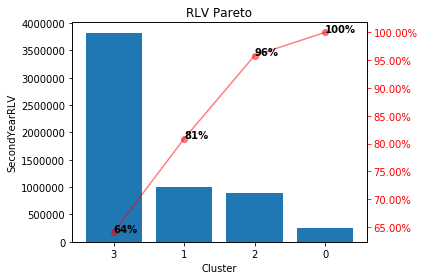

In [19]:
pareto_df = cluster_features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
pareto_df['Cluster'] = pareto_df['Cluster'].astype(str)
pareto_plot(pareto_df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

A Yeo-Johnson transform was used to map the feature distributions to a gaussian in order to create more evenly distributed clusters. After all, each segment needs to be large enough to make marketing to it and understanding it worthwhile. A segment containing 3-4 customers just isn't useful and is probably more easily identified by other means e.g. using percentiles. More discussion about the transform can be found at the bottom of this notebook.

Cluster 3 contains 320 customers (17.8% of the cohort) but accounts for 64% of the total second year residual lifetime value of the entire cohort. These are your most "valuable" customers based on revenue alone. Of course lifetime value of a customer is also dictated by customer retention, which recall is better predicted by BTYD models, but identifying high value short-term future spenders is successfully accomplished here by segmentation. The customers in this segment have the most frequent high value purchase days and are the longest term customers with respect to age. Not very surprising.   

Clusters 1 and 2 are much more interesting. Both clusters result in a similar mean second year RLV (£1714 vs £1725) but achieve it in very different ways. Cluster 2 customers have frequency=3.16 and monetary_value=£597 whereas Cluster 1 customers have frequency=6.71 and monetary_value=£266. Cluster 1 customers purchase over 2x more often but at less than half the purchase value compared to cluster 2 customers. These are two very different types of purchasing behaviours but are equally valuable in the short-term future. Also Cluster 1 customers are on average 36.8 days "older" than cluster 2 customers based on age but again, no information regarding repeat purchases is given, so age and recency shouldn't be interepreted too much. 

Cluster 0 is the opposite of cluster 3. The lowest frequency, low value, shortest term customers end up being the lowest future spenders. Not very surprising once again.

Clusters can be named as follows:

- Cluster 0: Lowest value
- Cluster 1: Frequent buyers
- Cluster 2: Big spenders
- Cluster 3: Highest value

where Frequent buyers and Big spenders are of approximately equal value in the short-term future.

Would RFM alone be able to identify these different customer segments? I would guess not but again I'm yet to try the scoring method and I have my doubts it will do any better than clustering on RFM. 

**Typical Customers of each Cluster**

Find the customers closest in features to the cluster centers and return their entire transaction history over the 2 years

In [20]:
closest, _ = pairwise_distances_argmin_min(cluster_centers, cluster_features[transformed_feature_names])
features_copy.iloc[closest]

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV,Cluster
1426,221.940,62.744761,105.05,240.00,788.93,4.0,89.0,50.477718,27.0,127.0,16784.0,3.0,245.0,247.0,192.820000,36.0,107.60,0
592,214.165,123.905543,76.15,416.60,1293.61,6.0,22.0,26.602631,9.0,73.0,14217.0,5.0,151.0,153.0,175.402000,13.0,2004.98,1
1707,412.620,205.125823,302.90,767.05,1895.19,4.0,63.0,48.675798,29.0,125.0,17667.0,3.0,219.0,280.0,480.163333,15.0,2055.51,2
883,508.640,402.633526,175.20,1575.98,9105.36,14.0,27.0,15.864005,2.0,53.0,15093.0,13.0,343.0,357.0,681.209231,7.0,4597.02,3


In [21]:
cluster_names = ['Lowest value', 'Frequent buyers', 'Big spenders', 'Highest value']
typical_customers = features.iloc[closest].CustomerID.values
daily_customer_revenues = cohort_invoices.groupby(["CustomerID", pd.Grouper(key='InvoiceDate', freq='D')])['Revenue'].sum().reset_index()
for name, customer in zip(cluster_names, typical_customers):
    print(f"{name} cluster")
    print(daily_customer_revenues[daily_customer_revenues.CustomerID==customer].to_string(index=False))
    print()

Lowest value cluster
 CustomerID InvoiceDate  Revenue
    16784.0  2010-03-28   210.47
    16784.0  2010-08-03   105.05
    16784.0  2010-10-31   240.00
    16784.0  2010-11-28   233.41
    16784.0  2011-11-20   107.60

Frequent buyers cluster
 CustomerID InvoiceDate  Revenue
    14217.0  2010-06-30   416.60
    14217.0  2010-08-05   272.48
    14217.0  2010-10-18   226.90
    14217.0  2010-11-09   201.43
    14217.0  2010-11-19    76.15
    14217.0  2010-11-28   100.05
    14217.0  2010-12-08   118.30
    14217.0  2011-01-07   102.50
    14217.0  2011-01-11    69.70
    14217.0  2011-02-01    88.30
    14217.0  2011-03-20   130.05
    14217.0  2011-04-08   112.80
    14217.0  2011-05-16   202.24
    14217.0  2011-06-08   165.36
    14217.0  2011-07-07    95.75
    14217.0  2011-09-01   126.50
    14217.0  2011-09-26   258.17
    14217.0  2011-10-13   102.95
    14217.0  2011-10-30    92.52
    14217.0  2011-11-15   105.76
    14217.0  2011-11-28   139.60
    14217.0  2011-12-08    94.

This is just an illustration of the cluster descriptions that I provided above and shows what the typical purchasing behaviour looks like for customers from each of the segments identified. 

**GMM**

What does the segments look like when using GMM to cluster on the same features?

In [22]:
cluster_feature_names = transformed_feature_names
scaler = StandardScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)

Cluster labels - 0 = Low value customer, 3 = High value customer
Silhouette Coefficient:0.08891591946880238
Mean 2nd year RLV: [ 874.556 1188.305 2353.796 7880.086]
Differences: [313.75, 1165.49, 5526.29]
Value Counts:
0    503
1    246
2    694
3    456
Name: Cluster, dtype: int64
Explained variance ratio: [0.41830064 0.2769082 ]
Total explained variance: 0.695208841064203


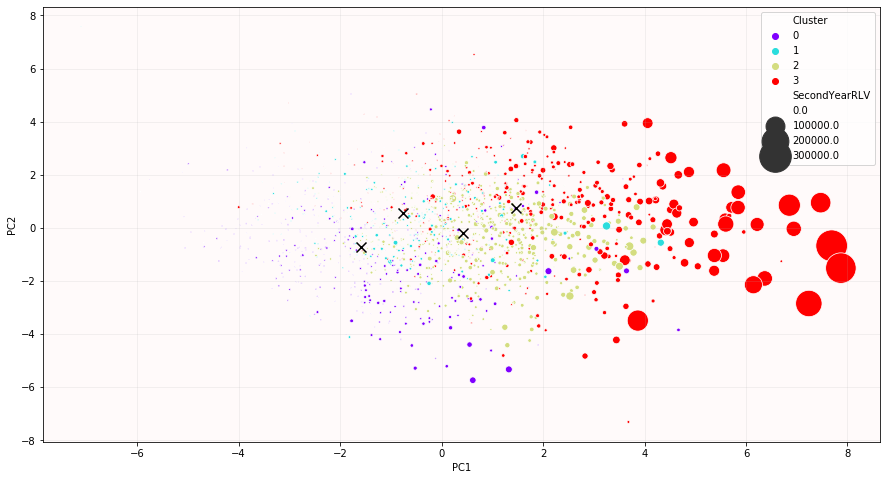

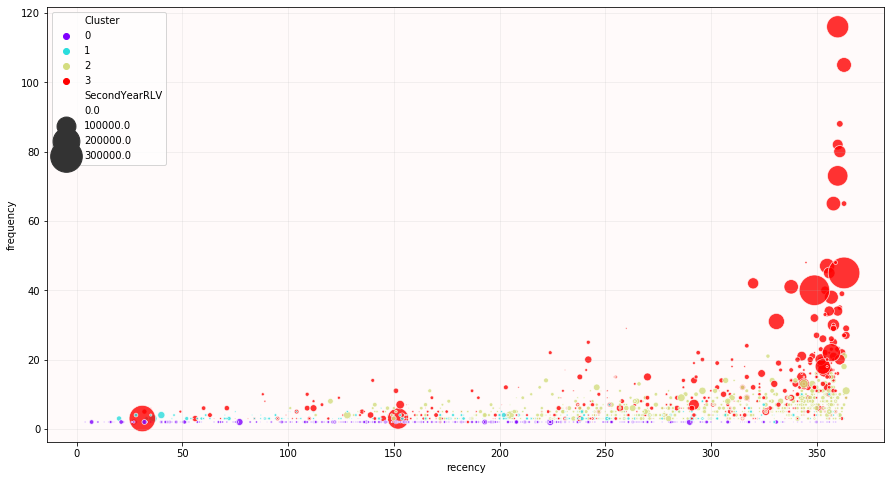

In [23]:
num_clusters = 4
cluster_features, cluster_centers, _  = perform_gmm_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [24]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=features_to_transform,
    index=['Component 1', 'Component 2']
)

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase
Component 1,0.297597,0.337401,0.069660,0.389678,0.446685,0.344361,-0.330561,-0.238875,-0.280295,-0.279081
Component 2,-0.415640,-0.252700,-0.411593,-0.327157,-0.168908,0.228350,-0.365923,-0.260104,-0.308154,-0.331299


**Pareto**

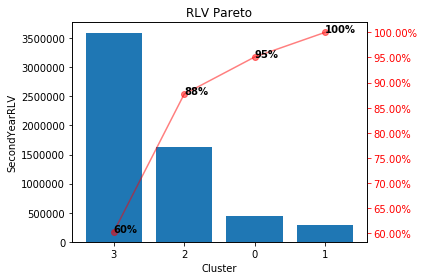

In [25]:
pareto_df = cluster_features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
pareto_df['Cluster'] = pareto_df['Cluster'].astype(str)
pareto_plot(pareto_df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

**Mean Cluster Features**

In [26]:
features_copy = features.copy()

# Inverse transform to see cluster features
if yjt:
    features_copy.drop(columns=transformed_feature_names, inplace=True)
    features_copy = pd.concat([
        pd.DataFrame(yjt.inverse_transform(features[transformed_feature_names]), columns=features_to_transform),
        features_copy
    ], axis=1)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
else:
    for transf_col, col in zip(transformed_feature_names, features_to_transform):
        features_copy[transf_col] = np.exp(features_copy[transf_col]) - 1
        features_copy.rename(columns={transf_col:col}, inplace=True)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
features_copy.groupby("Cluster").mean()

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
Cluster,,,,,,,,,,,,,,,,,
0,374.935924,172.927266,250.123638,578.953062,1204.012624,3.000000,89.880716,54.015648,51.685885,128.075547,15239.294235,2.000000,180.747515,245.250497,398.647078,81.252485,874.556362
1,309.296220,96.893787,217.080407,446.337276,1462.565122,4.597561,53.926829,25.289480,33.219512,83.813008,15598.268293,3.597561,196.890244,249.207317,313.820686,93.296748,1188.305366
2,392.072831,188.885384,219.628833,736.567349,2964.250677,6.894813,48.591499,37.087406,19.458213,105.340058,15331.341499,5.894813,281.102305,311.461095,420.537949,83.426513,2353.795951
3,524.750559,529.116814,128.068904,1788.460548,9079.839518,12.258772,30.646930,38.205874,5.565789,95.688596,15294.245614,11.258772,266.278509,302.164474,617.016719,86.973684,7880.085548


Cluster distributions are uneven but sizeable with the majority of customers being assigned to cluster 2. GMM clustering tends to enforce the RFM rule on both occasions (clustering on RFM and on aggregation features), so if the objective is to create a segmentation that agrees with RFM scoring then this segmentation is better. 

Where the algorithm is supposed to shine is model selection and soft clustering. It's obvious that soft clustering (assigning cluster label probabilities) would be useful in identifying the most likely segment members, and this is potentially useful information depending on what the next steps are after segmentation. Model selection is explored more in a separate notebook. 

It seems forcing the algorithm to create 4 segments has resulted in uneven segments that agree with the RFM rule, but overall it's unclear whether this is any better than KMeans in terms of clearly identifying the highest value short-term future customers whilst enforcing unique segments. I would say it's not any better. 

<br>
<br>

## Next steps - A marketing approach

TBD

<br>
<br>

## (Aside) Why transform?

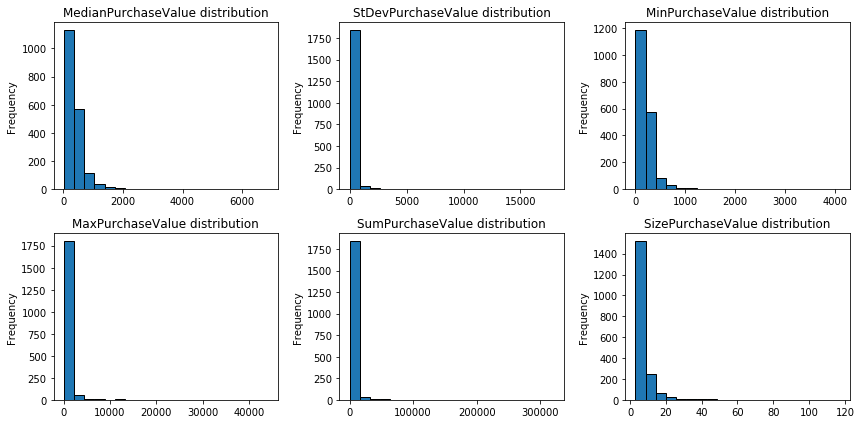

In [27]:
cluster = 0
fig = plt.figure(figsize=(12,6))
for idx, feat in enumerate(features_to_transform[:6]):
    ax = fig.add_subplot(2,3,idx+1)
    features_copy[feat].plot.hist(bins=20, ax=ax, edgecolor='k')
    ax.set_title(f"{feat} distribution")
plt.tight_layout()

Before transformation, all monetary aggregation features are right skewed. This exaggerates the difference between the highest spending customers and those who are relatively high spenders but don't spend as much. The clustering algorithms won't group these customers together unless the right side of the axis is "squashed" together which the transform seeks to achieve.